## Fitting ARIMA Model

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [27]:
#Import data
df  = pd.read_csv("Preprocessed_Data_with_only price.csv")

In [28]:
df

,Date,Price
0,2018-01-01 00:00:00,2676.94
1,2018-01-02 00:00:00,2680.82
2,2018-01-03 00:00:00,2679.15
3,2018-01-04 00:00:00,2669.70
4,2018-01-05 00:00:00,2686.88
...,...,...
1821,2022-12-27 00:00:00,4817.06
1822,2022-12-28 00:00:00,4798.47
1823,2022-12-29 00:00:00,4806.80
1824,2022-12-30 00:00:00,4829.89


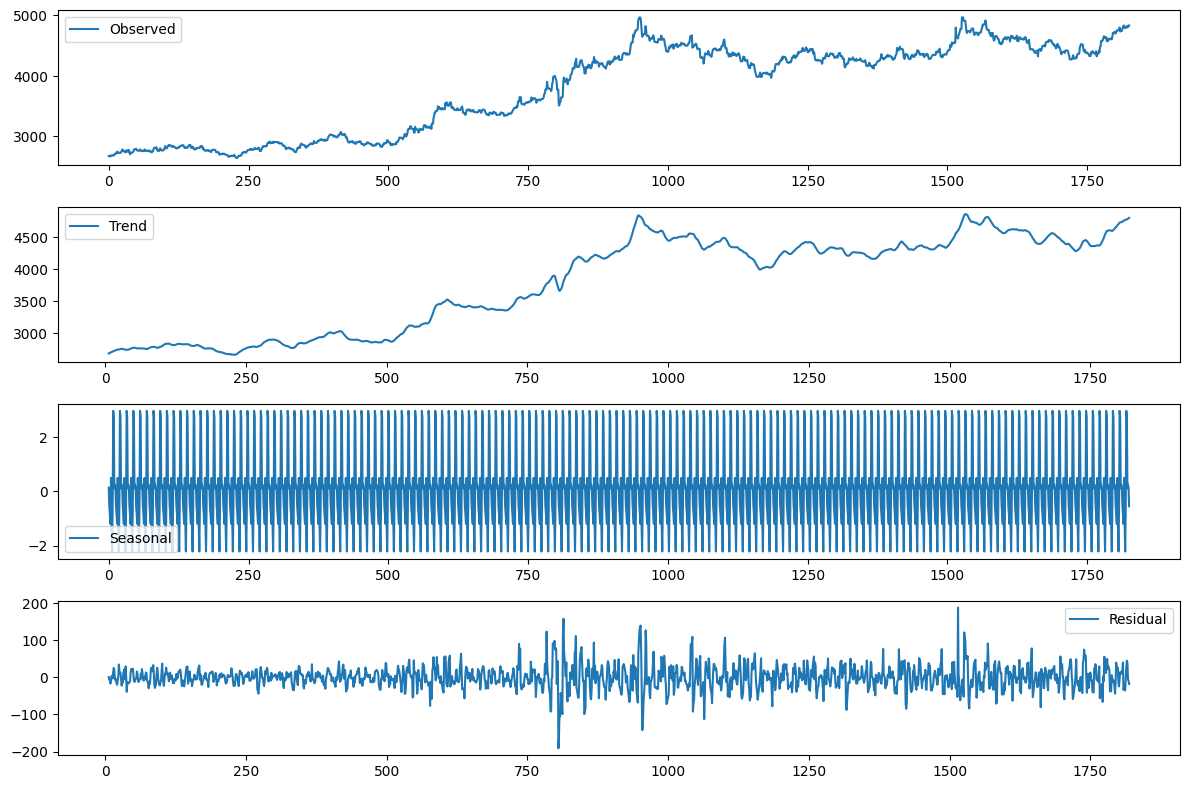

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ETS Decomposition
decomposition = seasonal_decompose(df['Price'], model='additive', period=12)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
observed = decomposition.observed

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


1. Observed (Top Panel)

This is the original time series data.

It shows a clear upward trend over time with significant fluctuations, particularly sharp increases around index 900 and 1500 (likely corresponding to events like the COVID pandemic or economic shifts).

There is cyclical behavior and volatility.

2. Trend (Second Panel)

This represents the long-term movement in the data, filtered from short-term fluctuations.

A clear upward trend is present, peaking around the same points as the observed data.

The trend smooths out local ups and downs and highlights overall growth in prices.

3. Seasonal (Third Panel)

This shows repeating patterns over a fixed period (likely daily, weekly, or monthly).

The seasonal component is highly regular, with consistent oscillations.

The amplitude (height of waves) is stable, suggesting predictable intra-period variation (e.g., daily or weekly market cycles).

4. Residual (Bottom Panel)

These are the leftover irregularities (random noise) after removing trend and seasonality.

Residuals vary in magnitude, especially around index 900–1100, which shows unusual volatility — potentially due to market shocks.

There's no clear pattern, which is ideal — residuals should be mostly random if the model captures trend and seasonality well.

# CONCLUSION

* The gold price time series has a strong upward trend.

* There is clear seasonality — perhaps due to monthly/quarterly trading cycles.

* The residuals are mostly noise, with some volatility spikes — possibly from economic events or speculation.

# Checking stationarity of the data using ADF Test

In [30]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -0.896326381745122
p-value: 0.7891797853936431


The data is non-stationary

# Finding the value of p,d,q for ARIMA model

# Plotting ACF graph

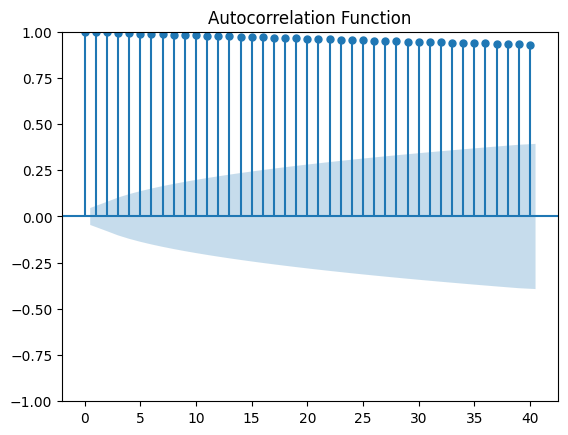

In [31]:
# Plot autocorrelation function to see correlation between price and its lagged values
plot_acf(df['Price'], lags=40)  # Plot correlations up to 40 days lag
plt.title('Autocorrelation Function')
plt.show()

X-axis (Lag): Indicates the lag (i.e., how many time steps back you're comparing).

Y-axis (Autocorrelation): Shows how strongly the series is correlated with itself at different lags.

Blue Bars: Represent the autocorrelation values at each lag.

Shaded Area (Confidence Interval): If the bar extends beyond this shaded region, the autocorrelation at that lag is statistically significant (i.e., unlikely to be due to random chance).

Interpretation:
* High Autocorrelation at All Lags:

* The autocorrelation remains close to 1.0 across all lags up to lag 40.

* This suggests strong persistence in the data—each value is very similar to previous values.

* This is typical of non-stationary data, such as trending time series (e.g., stock prices, cumulative metrics).

Conclusion:
The data is strongly autocorrelated and non-stationary.

# Plotting PACF Graph

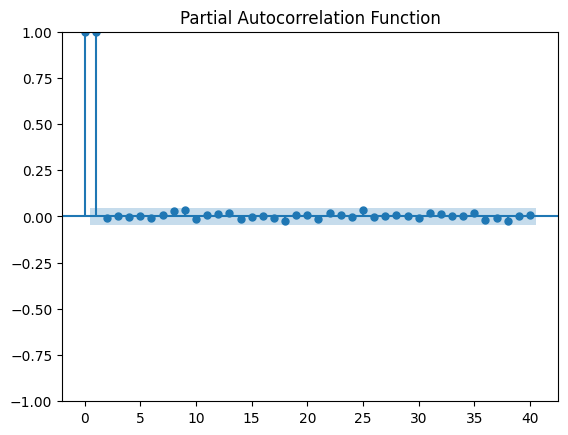

In [32]:
# Plot partial autocorrelation function to see direct correlation between price and lagged values excluding intermediate lags
plot_pacf(df['Price'], lags=40)
plt.title('Partial Autocorrelation Function')
plt.show()

This is a Partial Autocorrelation Function (PACF) plot, which helps identify the number of autoregressive (AR) terms needed in a time series model.

Key Components:
X-axis (Lag): The number of lags considered.

Y-axis (Partial Autocorrelation): Measures the direct correlation between the time series and its lagged version, after removing effects of intermediate lags.

Bars: Represent the partial autocorrelation at each lag.

Shaded Area: The 95% confidence interval—bars outside this region are statistically significant.

Interpretation:
* Significant Spike at Lag 1 (and maybe Lag 2):

* The first lag (and possibly the second) shows a strong and statistically significant partial autocorrelation.

* After lag 2, all values are within the confidence interval, indicating no significant additional direct lag effect.

Cut-off After Lag 1 or 2:

* This is characteristic of an AR(1) or possibly AR(2) process, meaning:

* The current value of the series is primarily influenced by the previous 1 or 2 values.

* This supports choosing p = 1 or 2 in an ARIMA or AR model.


Combined with ACF:
Since ACF shows slow decay and the PACF cuts off sharply after lag 1 or 2, this pattern strongly suggests an autoregressive, non-stationary series.

This is typical of a process that can be modeled with ARIMA(p, d, q) where:

p = 1 or 2

d = 1 (since ACF suggests non-stationarity)

q = 0 (as there's no significant lag in PACF beyond p)

# Finding the value of d

In [33]:
#Apply first-order differencing:
df['Price_diff'] = df['Price'].diff()

In [34]:
#Check stationarity
result1 = adfuller(df['Price_diff'].dropna())
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])


ADF Statistic: -17.219479690423817
p-value: 6.293430551973076e-30


The data is Stationary after differencing.

# Fit ARIMA Model

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(1,1,0)

In [54]:
# Model 1: ARIMA(1,1,0)
model_1 = ARIMA(df['Price'], order=(1,1,0), trend='t')
result_1 = model_1.fit()
print("ARIMA(1,1,0) AIC:", result_1.aic)

ARIMA(1,1,0) AIC: 17605.915948273243


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# ARIMA(2,1,0)

In [57]:
# Model 2: ARIMA(2,1,0)
model_2 = ARIMA(df['Price'], order=(2,1,0), trend='t')
result_2 = model_2.fit()
print("ARIMA(2,1,0) AIC:", result_2.aic)

ARIMA(2,1,0) AIC: 17607.905796260835


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


* 't' includes a linear time trend, allowing the model to capture gradual increases.

* Much more realistic over long horizons like 10 years.

# Conclusion:
ARIMA(1,1,0) has the lower AIC, so it's the better model of the two.

In [55]:
forecast_steps = 3650  #10 years
forecast = result_1.get_forecast(steps=forecast_steps)

# Extract the forecasted mean
forecast_mean = forecast.predicted_mean

# Extract confidence intervals
conf_int = forecast.conf_int()

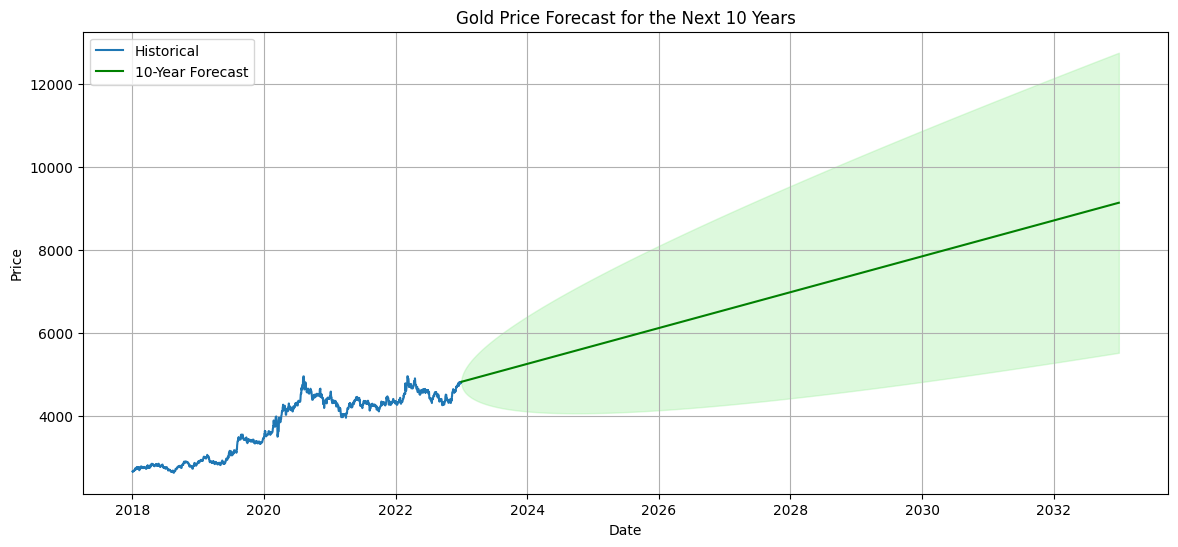

In [56]:
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq='D')

forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Historical')
plt.plot(forecast_series, label='10-Year Forecast', color='green')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3)
plt.title('Gold Price Forecast for the Next 10 Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



# Interpretation:

* Positive Growth Outlook:
The forecast suggests a long-term upward trend in gold prices, potentially driven by inflation, economic uncertainty, or model features that imply non-stationarity (e.g., using integrated or trend components).

* Confidence Interval:
While the central forecast points upward, the wide range reflects that prices could deviate significantly — from moderate growth to sharp acceleration or even stagnation.

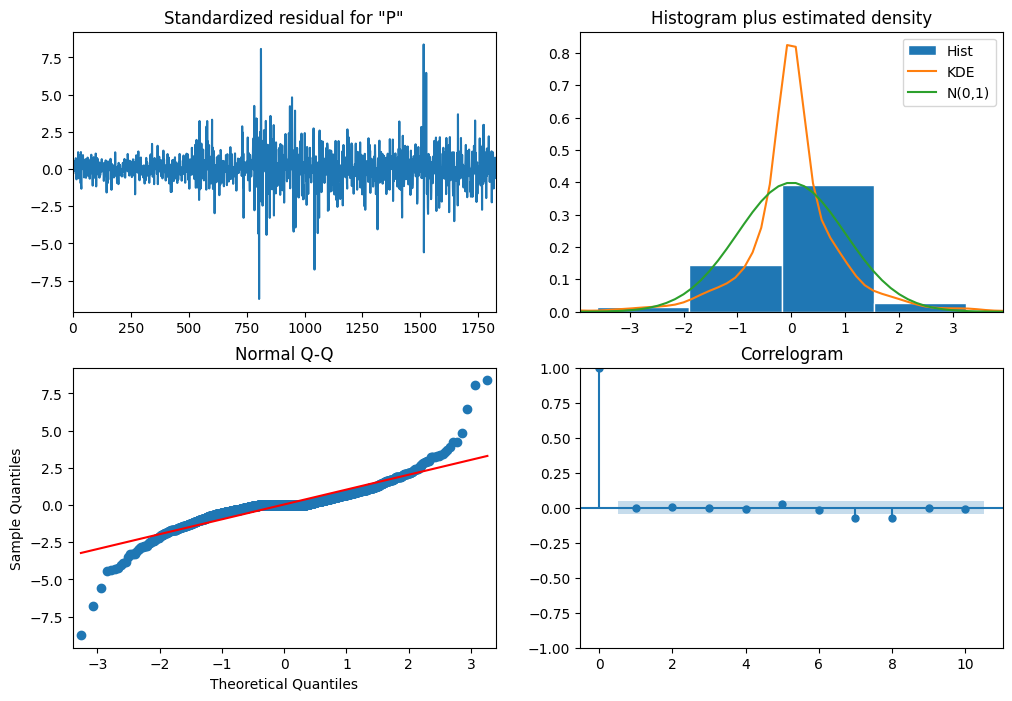

In [50]:
result_1.plot_diagnostics(figsize=(12, 8))
plt.show()

* Top Left: Standardized Residuals
This plot shows the standardized residuals over time.

Interpretation: The residuals should appear as white noise (randomly scattered around zero without patterns).

In your plot, there's a clear variation in spread over time (heteroskedasticity) and some outliers. This suggests the residuals are not homoscedastic and may not be purely random.

* Top Right: Histogram + KDE + Normal Curve
This shows a histogram of residuals (blue bars), a kernel density estimate (orange line), and a standard normal distribution curve (green line).

Interpretation: If residuals are normally distributed, the KDE and the normal curve should closely match.

In your case, the KDE is sharper and more peaked than the normal curve, suggesting leptokurtic distribution (heavy tails and peaked center), indicating non-normality.

* Bottom Left: Q-Q Plot
This quantile-quantile plot compares the distribution of residuals with a normal distribution.

Interpretation: Points should lie on the red 45-degree line if the residuals are normally distributed.

In your plot, the tails deviate substantially, further confirming non-normality and presence of outliers.

* Bottom Right: Correlogram (ACF Plot)
This shows autocorrelations of residuals for different lags.

Interpretation: If the model captured the structure well, most of the autocorrelation values should fall within the blue significance bounds.

Your plot shows no significant autocorrelation (except at lag 0), indicating the model has likely captured the autocorrelation structure of the data effectively.

* Summary:

Autocorrelation: Good (residuals are not autocorrelated).

Normality: Poor (residuals are not normally distributed; heavy tails and outliers are present).

Homoscedasticity: Poor (residual spread is not consistent over time).

Next Steps: You might consider:

Using a model that accounts for heteroskedasticity (e.g., GARCH).

Transforming the data to reduce kurtosis.

Investigating and possibly removing outliers.

## CONCLUSION:

ARIMA(1,10) is unreliable because it over-differences the data, removing useful trend information and reducing predictive power. It violates the principle of minimal differencing, where we only difference as much as needed to achieve stationarity.

# Calculate MSE

In [58]:
train_size = int(len(df) * 0.8)  # Use 80% data for training
train, test = df['Price'][:train_size], df['Price'][train_size:]

In [59]:
model = ARIMA(train, order=(1,1,0), trend='t')  
result = model.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [60]:
forecast_steps = len(test)
forecast = result.forecast(steps=forecast_steps)  # get forecasted values

In [61]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, forecast)
print(f'Test MSE: {mse}')

Test MSE: 42196.4554451664


In [62]:
#Calculate Sharpe ratio
import numpy as np

# Calculate daily returns (percentage or log returns)
returns = df['Price'].pct_change().dropna()  # or np.log(df['Price']).diff()

# Assume risk-free rate is zero (adjust if you want)
risk_free_rate = 0

# Excess returns
excess_returns = returns - risk_free_rate / 252  # daily risk-free rate if annual given

# Calculate Sharpe Ratio (annualized)
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

Sharpe Ratio: 0.7468992197014394


In [63]:
#Max Drawdown
def max_drawdown(prices):
    # Calculate cumulative max
    cumulative_max = prices.cummax()
    # Calculate drawdown
    drawdown = (prices - cumulative_max) / cumulative_max
    # Find max drawdown
    max_dd = drawdown.min()
    return max_dd

max_dd = max_drawdown(df['Price'])
print(f'Max Drawdown: {max_dd:.2%}')

Max Drawdown: -20.06%


In [65]:
import joblib
joblib.dump(model_1, 'models/arima_model.pkl')

['models/arima_model.pkl']